In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline for compatibility with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.colheader_justify', 'left')  # Align headers properly
pd.set_option('display.max_colwidth', None)  # Don't truncate column values

In [5]:
df_2017 =  pd.read_csv('/Users/emmalim/Desktop/DSA4263/2017_data.csv')
df_2018 =  pd.read_csv('/Users/emmalim/Desktop/DSA4263/ddos2018_cleaned.csv')

df_2017['Label'] = df_2017['Label'].apply(lambda x: 0 if x in ['BENIGN'] else 1)
df_2018['Label'] = df_2018['Label'].apply(lambda x: 0 if x in ['Benign'] else 1)

print("2017 Label distribution: ")
print(df_2017["Label"].value_counts())
print("2018 Label distribution: ")
print(df_2018["Label"].value_counts())


2017 Label distribution: 
Label
1    382665
0     97718
Name: count, dtype: int64
2018 Label distribution: 
Label
0    1343290
1     575394
Name: count, dtype: int64


# Initial Feature Selection and Engineering

## Analyse data distribution

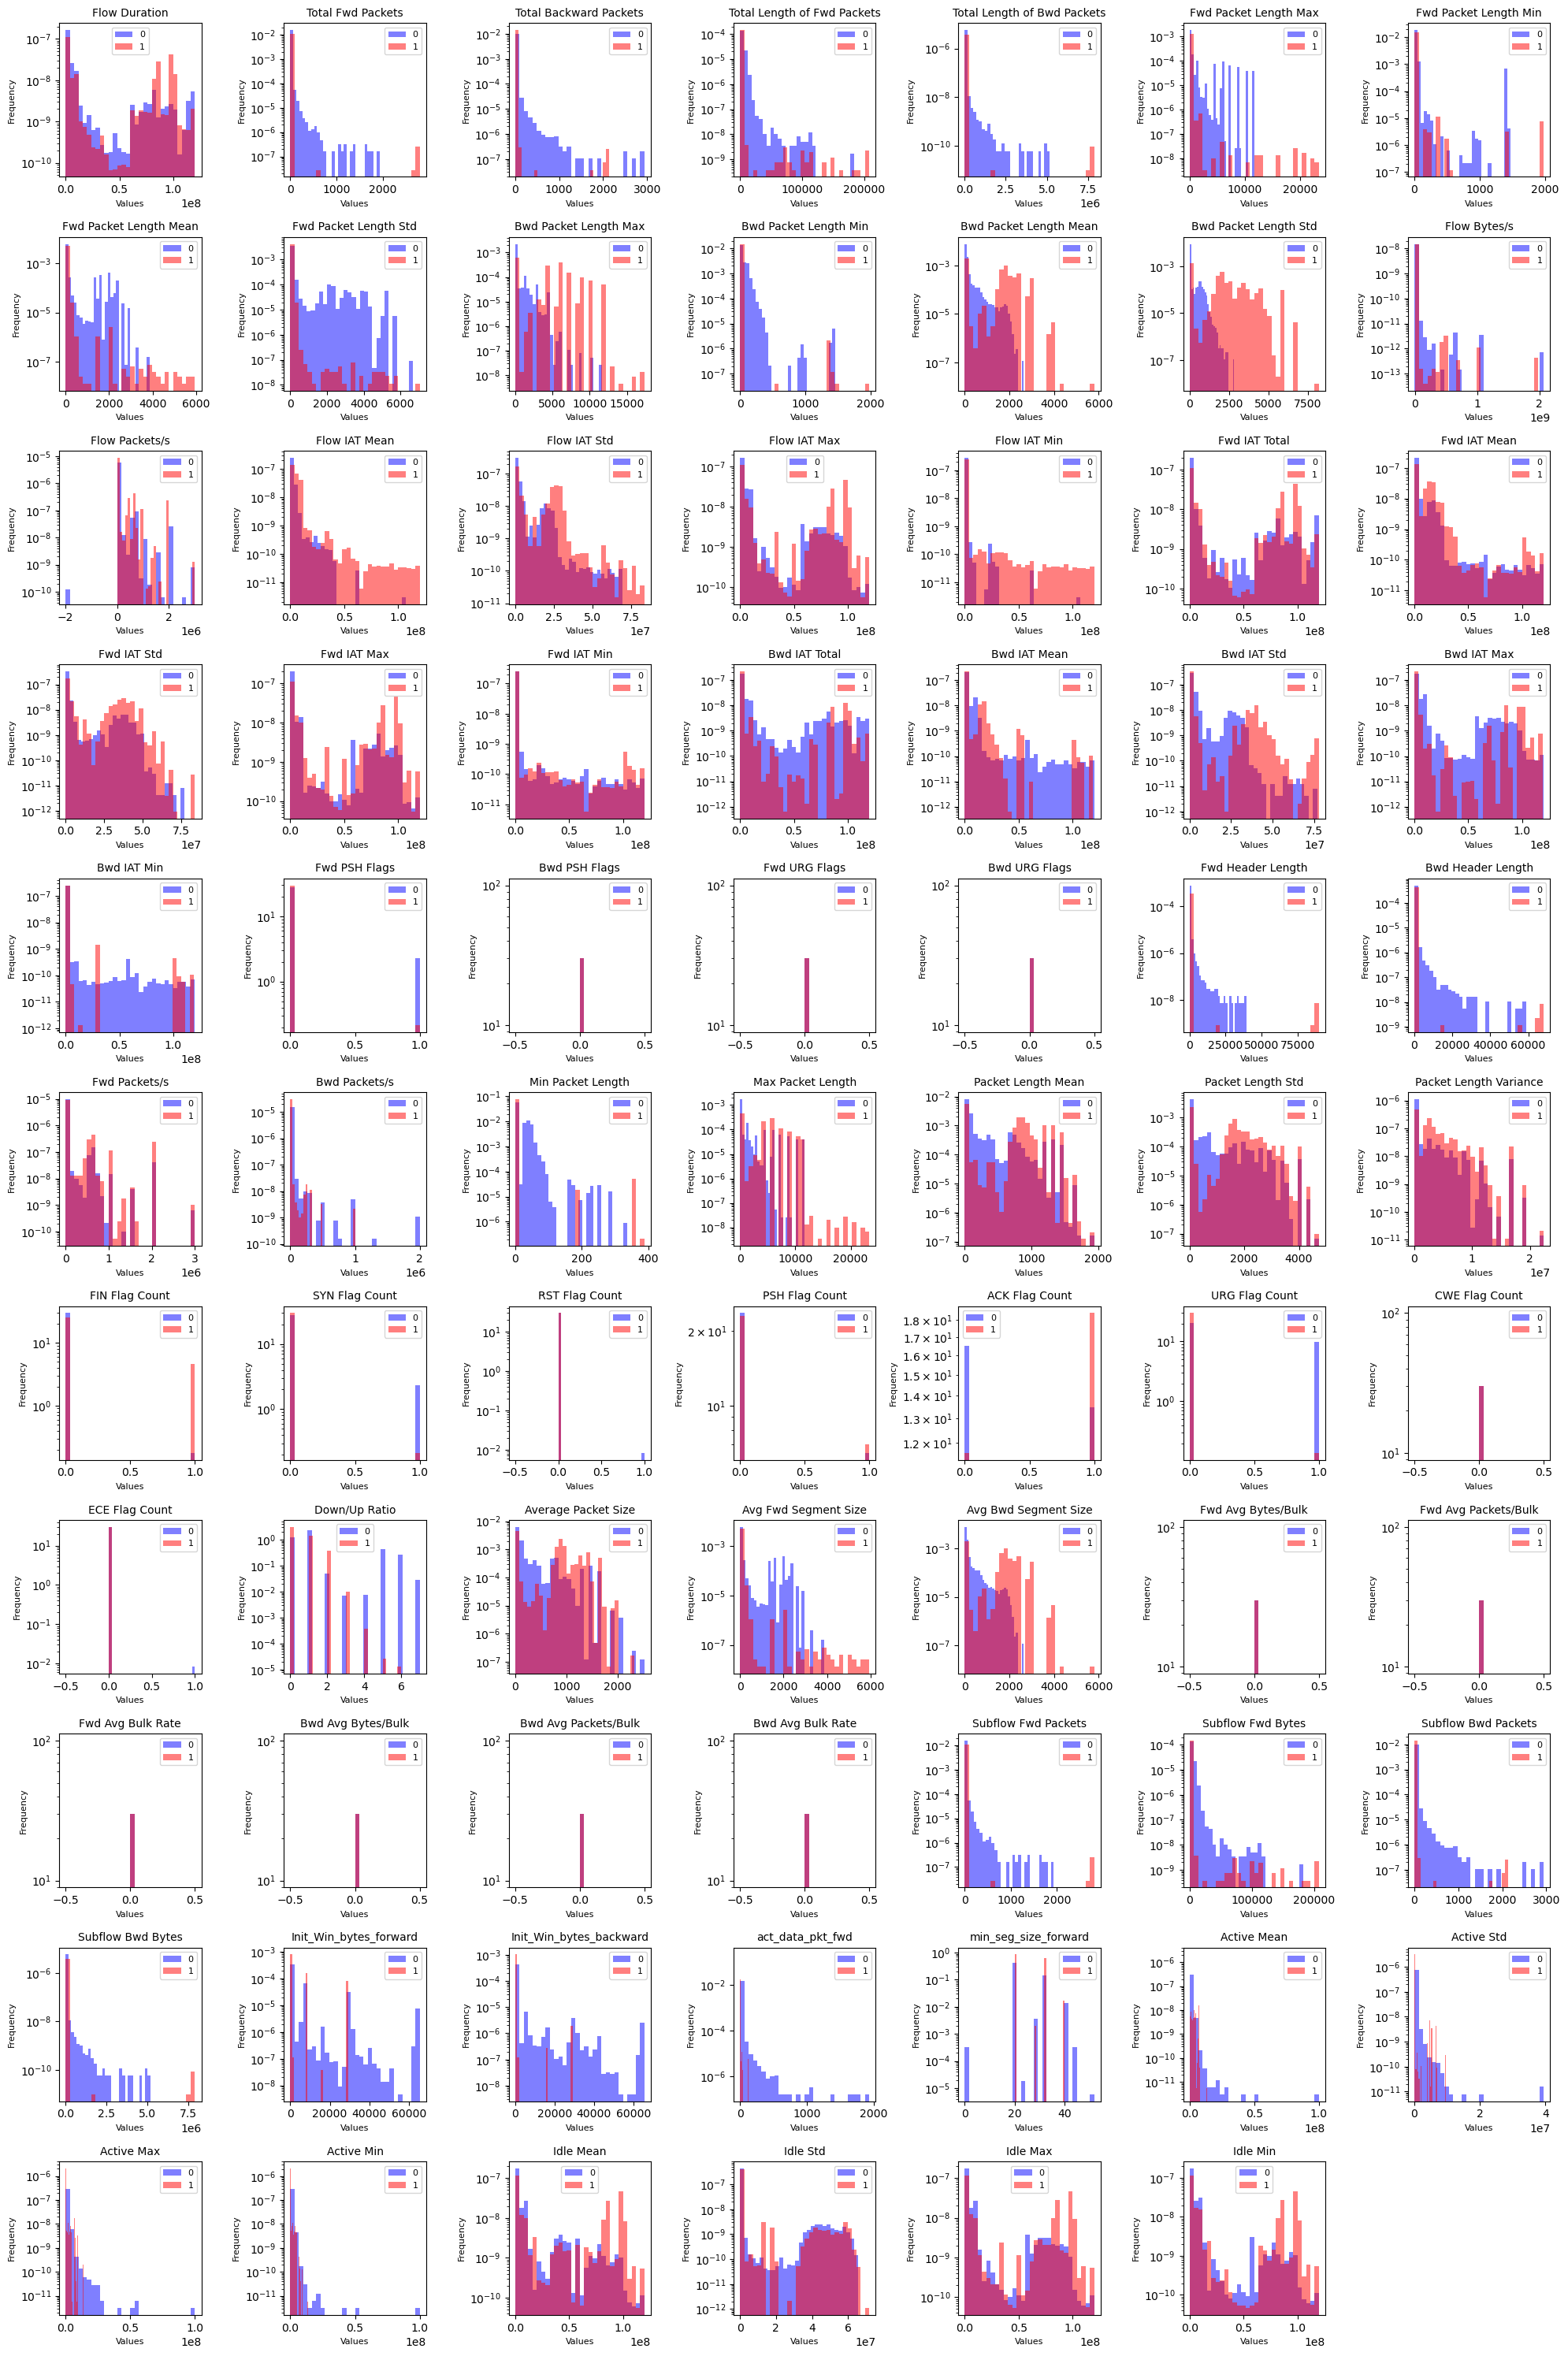

In [ ]:
# Convert to dtypes
df_2017['Label'] = df_2017['Label'].astype('category')
df_2017['Destination Port'] = df_2017['Destination Port'].astype('category')
df_2017['Source Port'] = df_2017['Source Port'].astype('category')
df_2017['Protocol'] = df_2017['Protocol'].astype('category')
df_2017['Timestamp'] = pd.to_datetime(df_2017['Timestamp'], errors='coerce')
numerical_cols = df_2017.select_dtypes(include=['number']).columns

# Define color mapping
label_colors = {0: 'blue', 1: 'red'}

# Set figure size
plt.figure(figsize=(20, 30))  # Adjusted for better spacing

rows, cols = 11, 7 
for i, column in enumerate(numerical_cols):  
    plt.subplot(rows, cols, i + 1)  

    for label, color in label_colors.items():
        subset = df_2017[df_2017['Label'] == label][column]
        
        # Remove NaN and infinite values
        subset = subset.replace([np.inf, -np.inf], np.nan).dropna()

        if not subset.empty:
            plt.hist(subset, bins=30, label=label, alpha=0.5, color=color, density=True)
    
    plt.title(column, fontsize=10)
    plt.xlabel('Values', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.yscale("log")  # Log scale for better separation
    plt.legend(fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

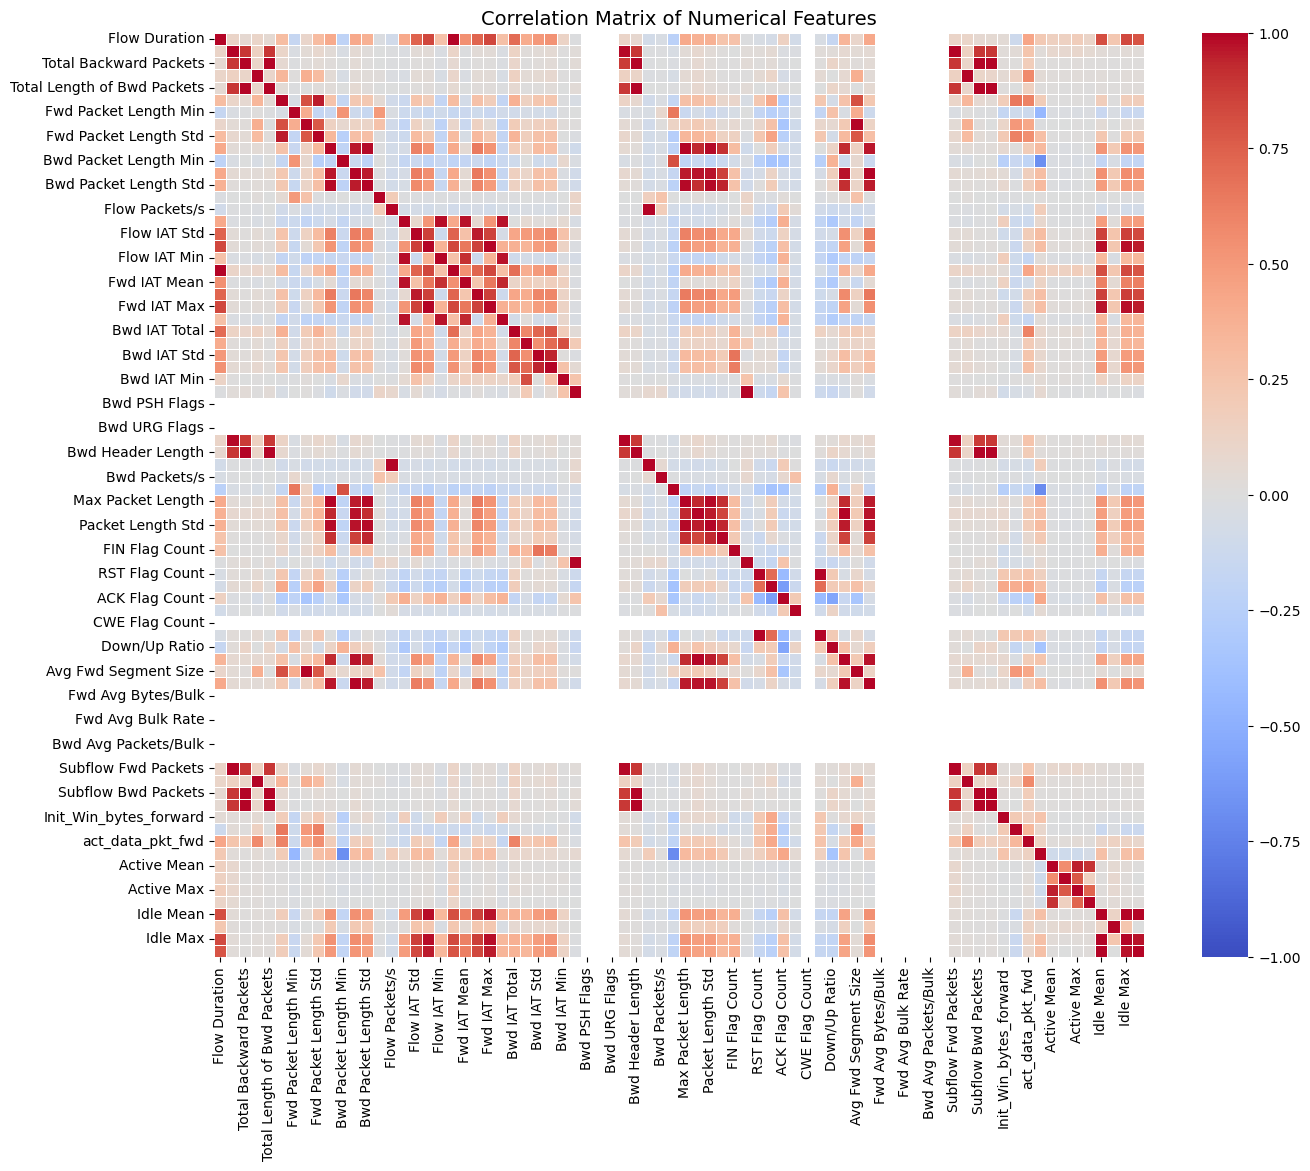

In [ ]:
# Compute correlation matrix
corr_matrix = df_2017[numerical_cols].corr()

# Set figure size
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Matrix of Numerical Features", fontsize=14)

# Show plot
plt.show()

### Identify uninformative features and features with high correlation

In [ ]:
#columns with no variance. 
no_variance_cols = df_2017.nunique()[df_2017.nunique() == 1].index

# Find columns with correlation greater than threshold (e.g., 0.9)
features = df_2017.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Label'])
corr_matrix = features.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.95
high_correlation = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

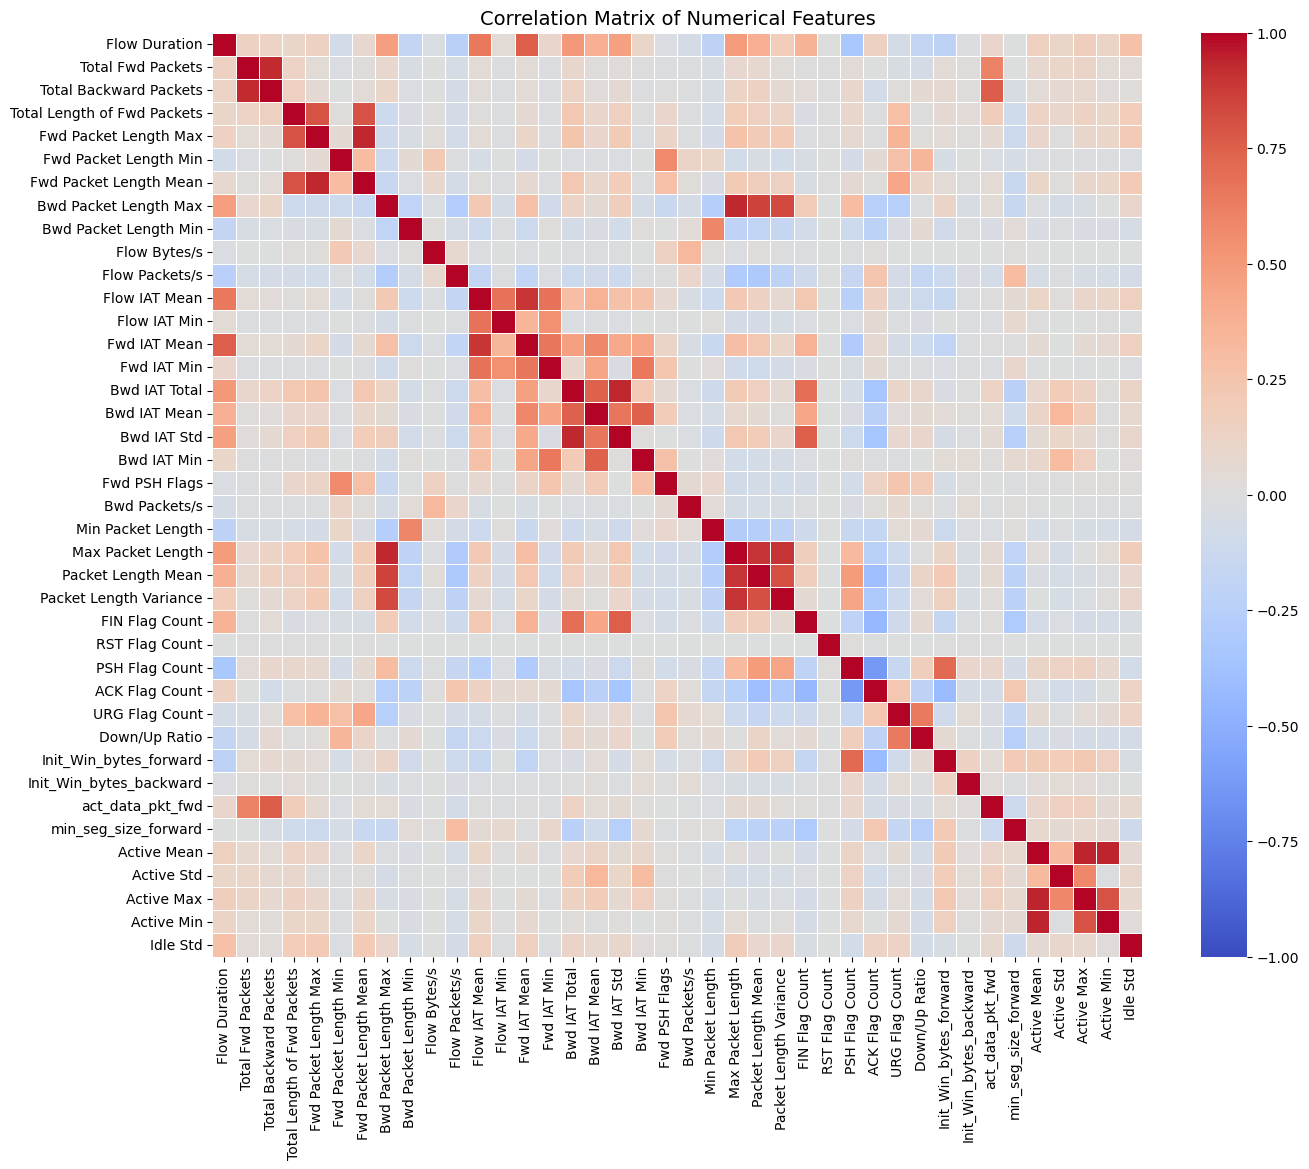

In [55]:
# Compute correlation matrix
numerical_cols = df_2017.select_dtypes(include=['number']).columns
corr_matrix = df_2017[numerical_cols].corr()

# Set figure size
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Matrix of Numerical Features", fontsize=14)

# Show plot
plt.show()

## Analyse protocol distribution

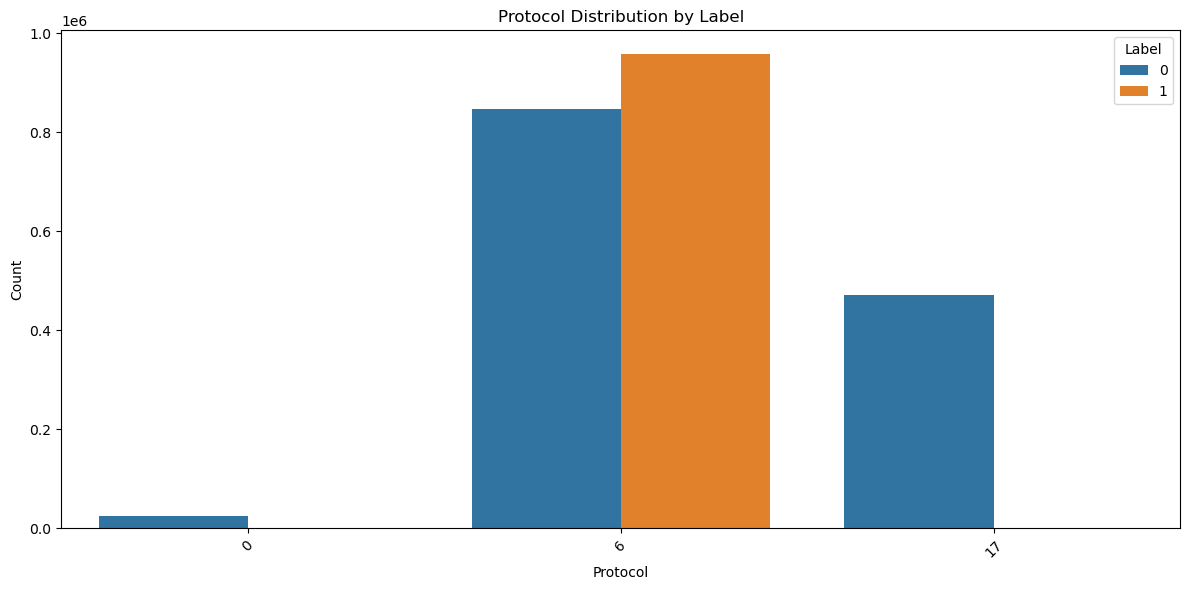

In [ ]:
# Plot for 'Protocol'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_2017, x='Protocol', hue='Label')
plt.title("Protocol Distribution by Label")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Selection and Engineering

In [ ]:
df_2017['Label'] = df_2017['Label'].astype('category')
df_2017['Protocol'] = df_2017['Protocol'].astype('category')
df_2018['Label'] = df_2018['Label'].astype('category')
df_2018['Protocol'] = df_2018['Protocol'].astype('category')

features_to_remove = high_correlation + no_variance_cols.tolist()

df_2017.drop(columns=features_to_remove , inplace=True, errors='ignore')
df_2018.drop(columns=features_to_remove , inplace=True, errors='ignore')

In [73]:
df_2017.replace([np.inf, -np.inf], np.nan, inplace=True)
df_2017.fillna(0, inplace=True) 
df_2017["Flow Bytes/s"].fillna(0, inplace=True)
df_2018.replace([np.inf, -np.inf], np.nan, inplace=True)
df_2018.fillna(0, inplace=True) 
df_2018["Flow Bytes/s"].fillna(0, inplace=True)

/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_37631/2190216298.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_2017["Flow Bytes/s"].fillna(0, inplace=True)
/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_37631/2190216298.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

### Encode protocol

In [74]:
protocol_ohe = pd.get_dummies(df_2017['Protocol'], prefix='Protocol')
df_2017 = pd.concat([df_2017, protocol_ohe], axis=1)

protocol_ohe = pd.get_dummies(df_2018['Protocol'], prefix='Protocol')
df_2018 = pd.concat([df_2018, protocol_ohe], axis=1)

In [75]:
nan_counts = df_2017.isna().sum()
nan_counts = df_2018.isna().sum()

In [76]:
print(df_2017['Label'].value_counts())
print(df_2018['Label'].value_counts())

df_2017_final = df_2017.copy()
df_2018_final = df_2018.copy()
df_2017_final.info()
df_2018_final.info()

Label
1    382665
0     97718
Name: count, dtype: int64
Label
0    1343290
1     575394
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480383 entries, 0 to 480382
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Flow ID                      480383 non-null  object  
 1   Source IP                    480383 non-null  object  
 2   Source Port                  480383 non-null  int64   
 3   Destination IP               480383 non-null  object  
 4   Destination Port             480383 non-null  int64   
 5   Protocol                     480383 non-null  category
 6   Timestamp                    480383 non-null  object  
 7   Flow Duration                480383 non-null  int64   
 8   Total Fwd Packets            480383 non-null  int64   
 9   Total Backward Packets       480383 non-null  int64   
 10  Total Length of Fwd Packets  480383 non-null  int6

In [12]:
# Save datasets for training and testing into csvs (after feature selection and initial feature engineering)
df_2017_final.to_csv('/Users/emmalim/Desktop/DSA4263/traindata_2017_v1.csv', index=False)
df_2018_final.to_csv('/Users/emmalim/Desktop/DSA4263/testdata_2018_v1.csv', index=False)

# Baseline Models

In [80]:
to_remove = ['Protocol', 'Flow ID', 'Source IP', 'Source Port', 'Destination Port', 'Destination IP', 'Timestamp'] 
df_2017_final.drop(columns=to_remove , inplace=True, errors='ignore')
df_2018_final.drop(columns=to_remove , inplace=True, errors='ignore')

In [81]:
# Separate features and target variables
X_train = df_2017_final.drop(columns=['Label'])
y_train = df_2017_final['Label']
X_test = df_2018_final.drop(columns=['Label'])
y_test = df_2018_final['Label']

In [82]:
print(df_2017_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480383 entries, 0 to 480382
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Flow Duration                480383 non-null  int64   
 1   Total Fwd Packets            480383 non-null  int64   
 2   Total Backward Packets       480383 non-null  int64   
 3   Total Length of Fwd Packets  480383 non-null  int64   
 4   Fwd Packet Length Max        480383 non-null  int64   
 5   Fwd Packet Length Min        480383 non-null  int64   
 6   Fwd Packet Length Mean       480383 non-null  float64 
 7   Bwd Packet Length Max        480383 non-null  int64   
 8   Bwd Packet Length Min        480383 non-null  int64   
 9   Flow Bytes/s                 480383 non-null  float64 
 10  Flow Packets/s               480383 non-null  float64 
 11  Flow IAT Mean                480383 non-null  float64 
 12  Flow IAT Min                 480383 non-null

### Logistic Regression

In [ ]:
#  Define Pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])


# Define Hyperparameter Grid
param_grid = {
    'lr__C': [0.01, 0.1, 1],  # Regularization strength
    'smote__k_neighbors': [3, 5, 7]  # SMOTE neighbor choices
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',    
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


# Best Model & Predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}\n")


# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pand

Best Parameters: {'lr__C': 0.01, 'smote__k_neighbors': 5}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87   1343290
           1       0.87      0.35      0.50    575394

    accuracy                           0.79   1918684
   macro avg       0.82      0.66      0.68   1918684
weighted avg       0.80      0.79      0.76   1918684

Confusion Matrix:
 [[1311767   31523]
 [ 372608  202786]]
Accuracy: 0.7894
Precision: 0.8655
Recall: 0.3524
F1 Score: 0.5009
ROC AUC Score: 0.7605


### ADABoost Model

In [ ]:
# Define AdaBoost Pipeline
adaboost_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('ada', AdaBoostClassifier(random_state=42))
])

# Define Hyperparameter Grid
adaboost_param_grid = {
    'ada__n_estimators': [50, 100],
    'ada__learning_rate': [0.5, 1.0, 1.5],
}

# Grid Search CV
adaboost_grid = GridSearchCV(
    estimator=adaboost_pipeline,
    param_grid=adaboost_param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

adaboost_grid.fit(X_train, y_train)


# Best Model & Predictions
best_ada = adaboost_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)
y_proba_ada = best_ada.predict_proba(X_test)[:, 1]

print(f"\n🔧 AdaBoost Best Parameters: {adaboost_grid.best_params_}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ada):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_ada):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ada):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_ada):.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits

🔧 AdaBoost Best Parameters: {'ada__learning_rate': 1.5, 'ada__n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86   1343290
           1       0.71      0.49      0.58    575394

    accuracy                           0.79   1918684
   macro avg       0.76      0.70      0.72   1918684
weighted avg       0.78      0.79      0.77   1918684

Confusion Matrix:
 [[1227940  115350]
 [ 296005  279389]]
Accuracy: 0.7856
Precision: 0.7078
Recall: 0.4856
F1 Score: 0.5760
ROC AUC Score: 0.8125
